# HCA-DR (Hierarchical Cell-Aware DrugReflector) 数据预处理

## 概述
本notebook实现HCA-DR模型所需的数据预处理流程：

1. **加载已处理的Level 4训练数据** - 扰动签名 $\mathbf{x}_{\text{pert}}$
2. **从Level 3 DMSO对照数据提取细胞系上下文** - $\mathbf{x}_{\text{ctx}}$
3. **计算每个plate的DMSO均值**
4. **应用Rank-based Inverse Normal Transformation (INT)归一化**
5. **构建细胞系ID映射**
6. **输出可直接用于HCA-DR训练的数据**

### 数学定义
- 扰动签名: $\mathbf{x}_{\text{pert}} \in \mathbb{R}^{978}$ (v-score变换后)
- 细胞系上下文: $\mathbf{x}_{\text{ctx}} \in \mathbb{R}^{978}$ (INT归一化后)
- 细胞系ID: $c \in \{1, 2, \ldots, C\}$
- 药物标签: $y \in \{1, 2, \ldots, D\}$

In [1]:
import numpy as np
import pandas as pd
import h5py
from pathlib import Path
import pickle
from scipy import stats
from scipy.stats import rankdata
from typing import Dict, Tuple, Optional, List
import warnings
import gc
from tqdm.notebook import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 1. 配置路径

In [2]:
# ==================== 配置路径 ====================
LINCS_DATA_DIR = Path("D:/科研/Models/drugreflector/datasets/LINCS2020")
PROCESSED_DATA_DIR = Path("D:/科研/Models/drugreflector/processed_data")
OUTPUT_DIR = Path("D:/科研/Models/drugreflector/processed_data")
VIZ_DIR = Path("D:/科研/Models/drugreflector/visualizations/hca_dr")

# 创建输出目录
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
VIZ_DIR.mkdir(exist_ok=True, parents=True)

# 输入文件
# TRAINING_DATA_FILE = "training_data_lincs2020_method1.pkl"
TRAINING_DATA_FILE = "training_data_lincs2020_chemfiltered_1201_l.pkl"
LEVEL3_CTL_FILE = "level3_beta_ctl_n188708x12328.gctx"
GENE_INFO_FILE = "geneinfo_beta.txt"
INST_INFO_FILE = "instinfo_beta.txt"

# 输出文件
OUTPUT_FILE = "hca_dr_training_data_l.pkl"

print("📁 Path Configuration:")
print(f"   LINCS data: {LINCS_DATA_DIR}")
print(f"   Processed data: {PROCESSED_DATA_DIR}")
print(f"   Output: {OUTPUT_DIR / OUTPUT_FILE}")

# 验证文件存在
files_to_check = [
    (PROCESSED_DATA_DIR / TRAINING_DATA_FILE, "Training data"),
    (LINCS_DATA_DIR / LEVEL3_CTL_FILE, "Level 3 control data"),
    (LINCS_DATA_DIR / GENE_INFO_FILE, "Gene info"),
    (LINCS_DATA_DIR / INST_INFO_FILE, "Instance info"),
]

print("\n📋 File Check:")
all_files_exist = True
for file_path, desc in files_to_check:
    exists = file_path.exists()
    status = "✓" if exists else "✗"
    print(f"   {status} {desc}: {file_path.name}")
    if not exists:
        all_files_exist = False

if not all_files_exist:
    print("\n⚠️  Some required files are missing!")

📁 Path Configuration:
   LINCS data: D:\科研\Models\drugreflector\datasets\LINCS2020
   Processed data: D:\科研\Models\drugreflector\processed_data
   Output: D:\科研\Models\drugreflector\processed_data\hca_dr_training_data_l.pkl

📋 File Check:
   ✓ Training data: training_data_lincs2020_chemfiltered_1201_l.pkl
   ✓ Level 3 control data: level3_beta_ctl_n188708x12328.gctx
   ✓ Gene info: geneinfo_beta.txt
   ✓ Instance info: instinfo_beta.txt


## 2. 加载基因信息和Landmark索引

In [3]:
def load_gene_info(gene_file: Path) -> Tuple[pd.DataFrame, np.ndarray]:
    """加载基因信息并获取landmark基因索引"""
    print("\n📖 Loading gene information...")
    gene_info = pd.read_csv(gene_file, sep='\t')
    
    print(f"   ✓ Total genes: {len(gene_info):,}")
    print(f"   ✓ Columns: {list(gene_info.columns)}")
    
    # 获取landmark基因
    landmark_mask = gene_info['feature_space'] == 'landmark'
    landmark_indices = np.where(landmark_mask.values)[0]
    
    print(f"   ✓ Landmark genes: {len(landmark_indices)}")
    
    return gene_info, landmark_indices

# 加载
gene_info, landmark_col_indices = load_gene_info(LINCS_DATA_DIR / GENE_INFO_FILE)

# 显示部分landmark基因
landmark_genes = gene_info[gene_info['feature_space'] == 'landmark']
print(f"\n   Sample landmark genes:")
print(landmark_genes[['gene_id', 'gene_symbol', 'gene_type']].head(10).to_string())


📖 Loading gene information...
   ✓ Total genes: 12,328
   ✓ Columns: ['gene_id', 'gene_symbol', 'ensembl_id', 'gene_title', 'gene_type', 'src', 'feature_space']
   ✓ Landmark genes: 978

   Sample landmark genes:
      gene_id gene_symbol       gene_type
2154       16        AARS  protein-coding
2155       23       ABCF1  protein-coding
2156       25        ABL1  protein-coding
2157       30       ACAA1  protein-coding
2158       39       ACAT2  protein-coding
2159       47        ACLY  protein-coding
2160      102      ADAM10  protein-coding
2161      128        ADH5  protein-coding
2162      142       PARP1  protein-coding
2163      154       ADRB2  protein-coding


## 3. 加载已处理的Level 4训练数据

In [4]:
def load_training_data(training_path: Path) -> Dict:
    """加载已处理的训练数据"""
    print("\n📖 Loading processed training data...")
    
    with open(training_path, 'rb') as f:
        training_data = pickle.load(f)
    
    n_samples = len(training_data['X'])
    n_compounds = len(training_data['compound_names'])
    n_genes = training_data['X'].shape[1]
    
    print(f"   ✓ Samples: {n_samples:,}")
    print(f"   ✓ Compounds: {n_compounds:,}")
    print(f"   ✓ Genes: {n_genes}")
    
    # 检查metadata
    meta = training_data['sample_meta']
    print(f"\n   📋 Metadata columns:")
    print(f"      {list(meta.columns[:15])}")
    
    # 提取plate信息（如果需要）
    if 'det_plate' not in meta.columns and 'sample_id' in meta.columns:
        print("\n   Extracting plate info from sample_id...")
        meta['det_plate'] = meta['sample_id'].apply(
            lambda x: x.split(':')[0] if ':' in str(x) else str(x).rsplit('_', 1)[0]
        )
        training_data['sample_meta'] = meta
    
    print(f"\n   📊 Statistics:")
    print(f"      • Cell lines: {meta['cell_iname'].nunique()}")
    print(f"      • Unique plates: {meta['det_plate'].nunique() if 'det_plate' in meta.columns else 'N/A'}")
    print(f"      • Memory: {training_data['X'].nbytes / (1024**3):.2f} GB")
    
    return training_data

# 加载训练数据
training_data = load_training_data(PROCESSED_DATA_DIR / TRAINING_DATA_FILE)


📖 Loading processed training data...
   ✓ Samples: 509,006
   ✓ Compounds: 10,107
   ✓ Genes: 978

   📋 Metadata columns:
      ['sample_id', 'bead_batch', 'nearest_dose', 'pert_dose', 'pert_dose_unit', 'pert_idose', 'pert_time', 'pert_itime', 'pert_time_unit', 'cell_mfc_name', 'pert_mfc_id', 'det_plate', 'det_well', 'rna_plate', 'rna_well']

   📊 Statistics:
      • Cell lines: 57
      • Unique plates: 4756
      • Memory: 1.85 GB



📊 Cell Line Distribution in Training Data:


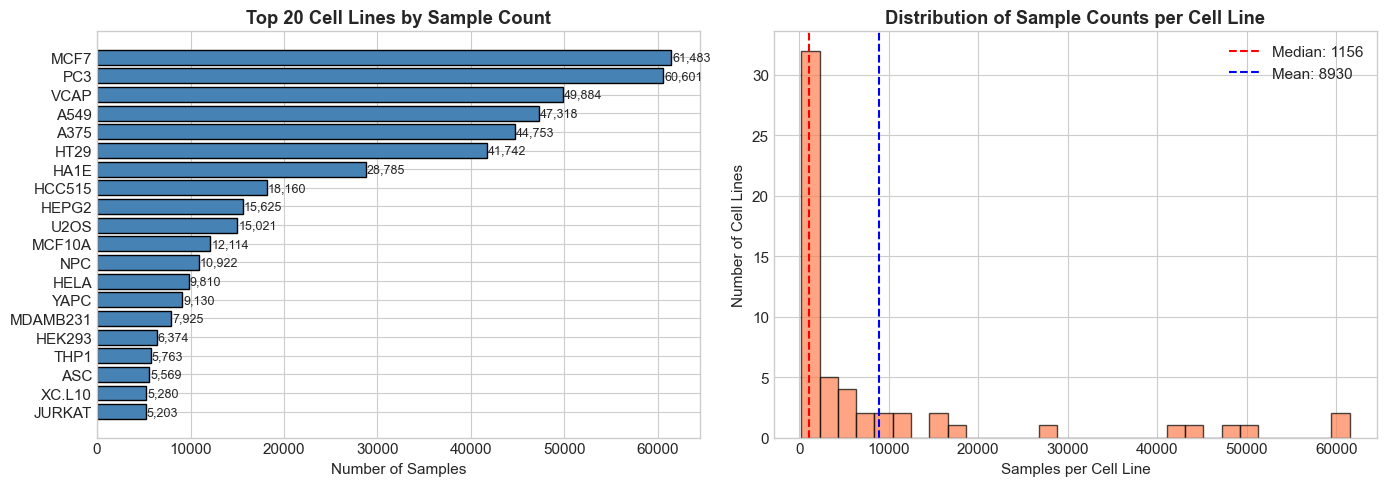


   Total cell lines: 57
   Mean samples/cell: 8929.9
   Median samples/cell: 1156


In [5]:
# 分析训练数据的细胞系分布
meta = training_data['sample_meta']

print("\n📊 Cell Line Distribution in Training Data:")
cell_counts = meta['cell_iname'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 柱状图：前20个细胞系
ax1 = axes[0]
top_cells = cell_counts.head(20)
bars = ax1.barh(range(len(top_cells)), top_cells.values, color='steelblue', edgecolor='black')
ax1.set_yticks(range(len(top_cells)))
ax1.set_yticklabels(top_cells.index)
ax1.set_xlabel('Number of Samples')
ax1.set_title('Top 20 Cell Lines by Sample Count', fontweight='bold')
ax1.invert_yaxis()

# 添加数值标签
for bar, val in zip(bars, top_cells.values):
    ax1.text(val + 100, bar.get_y() + bar.get_height()/2, f'{val:,}', va='center', fontsize=9)

# 直方图：样本数分布
ax2 = axes[1]
ax2.hist(cell_counts.values, bins=30, color='coral', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Samples per Cell Line')
ax2.set_ylabel('Number of Cell Lines')
ax2.set_title('Distribution of Sample Counts per Cell Line', fontweight='bold')
ax2.axvline(cell_counts.median(), color='red', linestyle='--', label=f'Median: {cell_counts.median():.0f}')
ax2.axvline(cell_counts.mean(), color='blue', linestyle='--', label=f'Mean: {cell_counts.mean():.0f}')
ax2.legend()

plt.tight_layout()
plt.savefig(VIZ_DIR / 'training_data_cell_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n   Total cell lines: {len(cell_counts)}")
print(f"   Mean samples/cell: {cell_counts.mean():.1f}")
print(f"   Median samples/cell: {cell_counts.median():.0f}")

## 4. 加载Level 3 DMSO对照数据

In [6]:
def load_level3_dmso_data(level3_file: Path, 
                          inst_file: Path,
                          landmark_indices: np.ndarray) -> Tuple[np.ndarray, pd.DataFrame]:
    """
    加载Level 3 DMSO对照数据
    
    Level 3数据包含未经z-score标准化的表达值
    用于计算细胞系上下文
    """
    print("\n" + "=" * 80)
    print("📖 Loading Level 3 DMSO Control Data")
    print("=" * 80)
    
    file_size_gb = level3_file.stat().st_size / (1024**3)
    print(f"File: {level3_file.name}")
    print(f"Size: {file_size_gb:.2f} GB")
    
    with h5py.File(level3_file, 'r') as f:
        # 检查数据路径
        matrix_dataset = f['/0/DATA/0/matrix']
        matrix_shape = matrix_dataset.shape
        print(f"\n   Matrix shape: {matrix_shape}")
        
        # 读取元数据
        print("\n📋 Loading metadata...")
        sample_meta = {}
        for key in f['/0/META/ROW'].keys():
            data = f[f'/0/META/ROW/{key}'][:]
            if data.dtype.kind in ['S', 'O', 'U']:
                try:
                    sample_meta[key] = np.char.decode(data.astype('S'), 'utf-8')
                except:
                    sample_meta[key] = data.astype(str)
            else:
                sample_meta[key] = data
        
        sample_df = pd.DataFrame(sample_meta)
        
        # 检测并处理ROW/COL交换
        if len(sample_df) == matrix_shape[1]:
            print("   ⚠️  Detected ROW/COL swap...")
            # 重新读取
            gene_meta = sample_meta
            sample_meta = {}
            for key in f['/0/META/COL'].keys():
                data = f[f'/0/META/COL/{key}'][:]
                if data.dtype.kind in ['S', 'O', 'U']:
                    try:
                        sample_meta[key] = np.char.decode(data.astype('S'), 'utf-8')
                    except:
                        sample_meta[key] = data.astype(str)
                else:
                    sample_meta[key] = data
            sample_df = pd.DataFrame(sample_meta)
        
        print(f"   Sample metadata: {len(sample_df)} entries")
        
        # 加载landmark基因数据（分块）
        print("\n🔬 Loading landmark gene data...")
        chunk_size = 50000
        chunks = []
        
        for start_idx in range(0, matrix_shape[0], chunk_size):
            end_idx = min(start_idx + chunk_size, matrix_shape[0])
            pct = end_idx / matrix_shape[0] * 100
            print(f"   Loading rows {start_idx:,} to {end_idx:,}... ({pct:.1f}%)", end='\r')
            
            chunk = matrix_dataset[start_idx:end_idx, landmark_indices].astype(np.float32)
            chunks.append(chunk)
        
        print()
        matrix = np.vstack(chunks)
        del chunks
        gc.collect()
        
        print(f"   ✓ Matrix shape: {matrix.shape}")
        print(f"   ✓ Memory: {matrix.nbytes / (1024**3):.2f} GB")
    
    # 处理sample_id
    if 'id' in sample_df.columns:
        sample_df = sample_df.rename(columns={'id': 'sample_id'})
    
    # 与instinfo合并
    if inst_file.exists():
        print("\n📖 Merging with instance info...")
        inst_info = pd.read_csv(inst_file, sep='\t')
        
        if 'sample_id' in sample_df.columns and 'sample_id' in inst_info.columns:
            sample_df = sample_df.merge(inst_info, on='sample_id', how='left')
            print(f"   ✓ Merged successfully")
    
    print(f"\n   ✓ Level 3 data loaded: {len(matrix):,} samples")
    
    return matrix, sample_df

# 加载Level 3数据
level3_matrix, level3_meta = load_level3_dmso_data(
    LINCS_DATA_DIR / LEVEL3_CTL_FILE,
    LINCS_DATA_DIR / INST_INFO_FILE,
    landmark_col_indices
)


📖 Loading Level 3 DMSO Control Data
File: level3_beta_ctl_n188708x12328.gctx
Size: 17.33 GB

   Matrix shape: (188708, 12328)

📋 Loading metadata...
   ⚠️  Detected ROW/COL swap...
   Sample metadata: 188708 entries

🔬 Loading landmark gene data...
   Loading rows 150,000 to 188,708... (100.0%)
   ✓ Matrix shape: (188708, 978)
   ✓ Memory: 0.69 GB

📖 Merging with instance info...
   ✓ Merged successfully

   ✓ Level 3 data loaded: 188,708 samples


In [7]:
# 检查Level 3元数据
print("\n📋 Level 3 Metadata Overview:")
print(f"   Columns: {list(level3_meta.columns[:20])}")
print(f"\n   Sample row:")
print(level3_meta.iloc[0][['sample_id', 'cell_iname', 'pert_type', 'pert_iname', 'det_plate']].to_string() 
      if all(col in level3_meta.columns for col in ['sample_id', 'cell_iname', 'pert_type', 'pert_iname', 'det_plate']) 
      else level3_meta.iloc[0].head(10).to_string())


📋 Level 3 Metadata Overview:
   Columns: ['sample_id', 'bead_batch', 'nearest_dose', 'pert_dose', 'pert_dose_unit', 'pert_idose', 'pert_time', 'pert_itime', 'pert_time_unit', 'cell_mfc_name', 'pert_mfc_id', 'det_plate', 'det_well', 'rna_plate', 'rna_well', 'count_mean', 'count_cv', 'qc_f_logp', 'qc_iqr', 'qc_slope']

   Sample row:
sample_id         ABY001_A375_XH_X1_B15:A03
bead_batch                              b15
nearest_dose                            NaN
pert_dose                               NaN
pert_dose_unit                          NaN
pert_idose                              NaN
pert_time                               3.0
pert_itime                              3 h
pert_time_unit                            h
cell_mfc_name                          A375


## 5. 计算Plate-Matched DMSO均值

In [8]:
def compute_plate_dmso_means(matrix: np.ndarray, 
                              meta: pd.DataFrame) -> Dict[str, np.ndarray]:
    """
    计算每个实验板的DMSO对照均值
    
    这是细胞系上下文 x_ctx 的原始值（INT归一化前）
    """
    print("\n" + "=" * 80)
    print("🧪 Computing Plate-Matched DMSO Means")
    print("=" * 80)
    
    # 确定plate列
    plate_col = None
    for col in ['det_plate', 'rna_plate']:
        if col in meta.columns:
            plate_col = col
            break
    
    if plate_col is None and 'sample_id' in meta.columns:
        # 从sample_id提取
        meta['det_plate'] = meta['sample_id'].apply(
            lambda x: x.split(':')[0] if ':' in str(x) else str(x).rsplit('_', 1)[0]
        )
        plate_col = 'det_plate'
    
    print(f"   Using '{plate_col}' as plate identifier")
    
    # 过滤DMSO样本
    if 'pert_type' in meta.columns:
        dmso_mask = meta['pert_type'] == 'ctl_vehicle'
    elif 'pert_iname' in meta.columns:
        dmso_mask = meta['pert_iname'].str.upper() == 'DMSO'
    else:
        dmso_mask = np.ones(len(meta), dtype=bool)
        print("   ⚠️  Using all samples as controls")
    
    print(f"   ✓ DMSO samples: {dmso_mask.sum():,}")
    
    # 按plate分组计算均值
    unique_plates = meta.loc[dmso_mask, plate_col].unique()
    print(f"   ✓ Unique plates: {len(unique_plates):,}")
    
    dmso_plate_means = {}
    samples_per_plate = []
    
    for plate in tqdm(unique_plates, desc="   Processing plates"):
        plate_mask = (meta[plate_col] == plate) & dmso_mask
        plate_indices = np.where(plate_mask)[0]
        
        if len(plate_indices) > 0:
            plate_mean = matrix[plate_indices].mean(axis=0)
            dmso_plate_means[plate] = plate_mean
            samples_per_plate.append(len(plate_indices))
    
    print(f"\n   ✓ Computed means for {len(dmso_plate_means):,} plates")
    print(f"   ✓ Samples per plate: mean={np.mean(samples_per_plate):.1f}, "
          f"median={np.median(samples_per_plate):.0f}")
    
    return dmso_plate_means

# 计算plate均值
dmso_plate_means = compute_plate_dmso_means(level3_matrix, level3_meta)


🧪 Computing Plate-Matched DMSO Means
   Using 'det_plate' as plate identifier
   ✓ DMSO samples: 102,696
   ✓ Unique plates: 5,937


   Processing plates:   0%|          | 0/5937 [00:00<?, ?it/s]


   ✓ Computed means for 5,937 plates
   ✓ Samples per plate: mean=17.3, median=19


## 6. 计算细胞系上下文向量

In [9]:
def compute_cell_line_contexts(meta: pd.DataFrame,
                                dmso_plate_means: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    """
    计算每个细胞系的上下文向量
    
    对于每个细胞系，计算其所有plate的DMSO均值的平均
    """
    print("\n" + "=" * 80)
    print("🔬 Computing Cell Line Context Vectors")
    print("=" * 80)
    
    # 确定列名
    cell_col = 'cell_iname' if 'cell_iname' in meta.columns else 'cell_mfc_name'
    plate_col = 'det_plate' if 'det_plate' in meta.columns else 'rna_plate'
    
    print(f"   Using '{cell_col}' as cell identifier")
    print(f"   Using '{plate_col}' as plate identifier")
    
    # 构建 cell -> plates 映射
    cell_to_plates = defaultdict(set)
    
    for plate in dmso_plate_means.keys():
        plate_meta = meta[meta[plate_col] == plate]
        if len(plate_meta) > 0:
            cells = plate_meta[cell_col].unique()
            for cell in cells:
                cell_to_plates[cell].add(plate)
    
    print(f"   ✓ Cell lines with DMSO data: {len(cell_to_plates)}")
    
    # 计算每个细胞系的上下文
    cell_contexts = {}
    plates_per_cell = []
    
    for cell, plates in tqdm(cell_to_plates.items(), desc="   Computing contexts"):
        plate_means = [dmso_plate_means[p] for p in plates if p in dmso_plate_means]
        if plate_means:
            cell_context = np.mean(plate_means, axis=0)
            cell_contexts[cell] = cell_context
            plates_per_cell.append(len(plate_means))
    
    print(f"\n   ✓ Computed contexts for {len(cell_contexts)} cell lines")
    print(f"   ✓ Plates per cell line: mean={np.mean(plates_per_cell):.1f}, "
          f"median={np.median(plates_per_cell):.0f}")
    
    return cell_contexts

# 计算细胞系上下文
cell_contexts_raw = compute_cell_line_contexts(level3_meta, dmso_plate_means)


🔬 Computing Cell Line Context Vectors
   Using 'cell_iname' as cell identifier
   Using 'det_plate' as plate identifier
   ✓ Cell lines with DMSO data: 227


   Computing contexts:   0%|          | 0/227 [00:00<?, ?it/s]


   ✓ Computed contexts for 227 cell lines
   ✓ Plates per cell line: mean=26.2, median=3



📊 Visualizing Raw Cell Line Contexts...


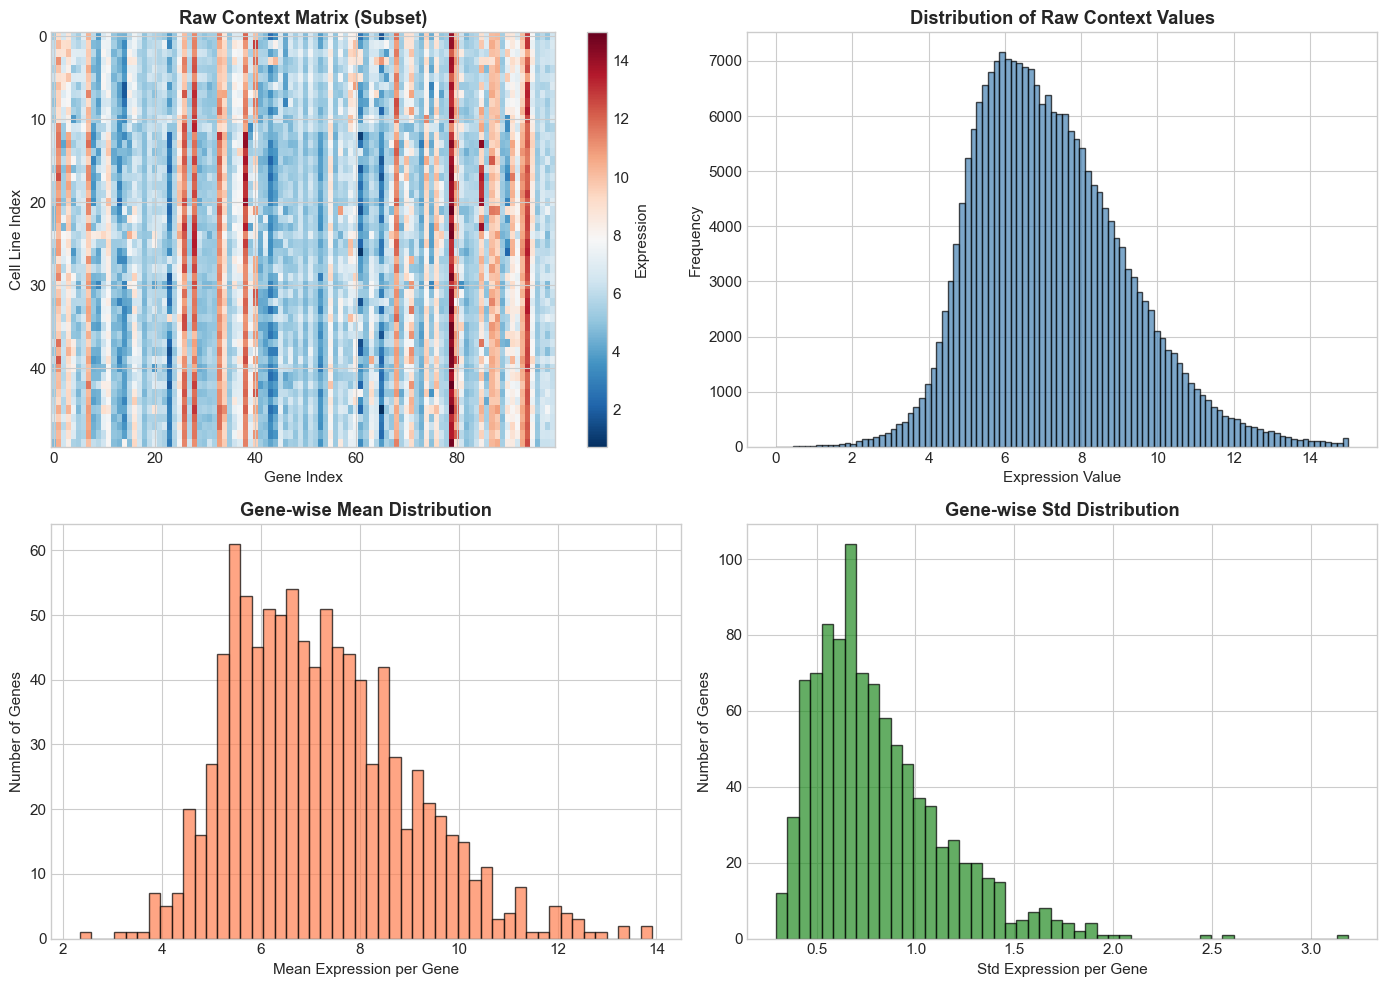


   Raw context statistics:
      • Overall mean: 7.1954
      • Overall std: 1.9841
      • Min: 0.0000
      • Max: 15.0053


In [10]:
# 可视化原始上下文
print("\n📊 Visualizing Raw Cell Line Contexts...")

# 转换为矩阵
cell_ids = list(cell_contexts_raw.keys())
context_matrix_raw = np.array([cell_contexts_raw[c] for c in cell_ids])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 热图（前50个细胞系，前100个基因）
ax1 = axes[0, 0]
n_cells_show = min(50, len(cell_ids))
n_genes_show = 100
im = ax1.imshow(context_matrix_raw[:n_cells_show, :n_genes_show], aspect='auto', cmap='RdBu_r')
ax1.set_xlabel('Gene Index')
ax1.set_ylabel('Cell Line Index')
ax1.set_title('Raw Context Matrix (Subset)', fontweight='bold')
plt.colorbar(im, ax=ax1, label='Expression')

# 基因表达分布
ax2 = axes[0, 1]
ax2.hist(context_matrix_raw.flatten(), bins=100, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Expression Value')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Raw Context Values', fontweight='bold')

# 每个基因的均值分布
ax3 = axes[1, 0]
gene_means = context_matrix_raw.mean(axis=0)
ax3.hist(gene_means, bins=50, color='coral', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Mean Expression per Gene')
ax3.set_ylabel('Number of Genes')
ax3.set_title('Gene-wise Mean Distribution', fontweight='bold')

# 每个基因的标准差分布
ax4 = axes[1, 1]
gene_stds = context_matrix_raw.std(axis=0)
ax4.hist(gene_stds, bins=50, color='forestgreen', edgecolor='black', alpha=0.7)
ax4.set_xlabel('Std Expression per Gene')
ax4.set_ylabel('Number of Genes')
ax4.set_title('Gene-wise Std Distribution', fontweight='bold')

plt.tight_layout()
plt.savefig(VIZ_DIR / 'raw_context_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n   Raw context statistics:")
print(f"      • Overall mean: {context_matrix_raw.mean():.4f}")
print(f"      • Overall std: {context_matrix_raw.std():.4f}")
print(f"      • Min: {context_matrix_raw.min():.4f}")
print(f"      • Max: {context_matrix_raw.max():.4f}")

## 7. 应用Rank-based Inverse Normal Transformation (INT)

In [11]:
def apply_rank_based_int(contexts: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    """
    应用Rank-based Inverse Normal Transformation (INT)
    
    对于每个基因，计算其在所有细胞系上下文中的排名，
    然后转换为标准正态分位数
    
    公式：
    r_{g,i} = rank({x_ctx,g^{(j)}}_{j=1}^N)
    tilde{x}_{ctx,g}^{(i)} = Φ^{-1}(r_{g,i} / (N+1))
    """
    print("\n" + "=" * 80)
    print("📊 Applying Rank-based Inverse Normal Transformation (INT)")
    print("=" * 80)
    
    cell_ids = list(contexts.keys())
    n_cells = len(cell_ids)
    n_genes = len(list(contexts.values())[0])
    
    print(f"   Cell lines: {n_cells}")
    print(f"   Genes: {n_genes}")
    
    # 构建矩阵
    context_matrix = np.array([contexts[c] for c in cell_ids])
    
    # 对每个基因应用INT
    print("\n   Applying INT per gene...")
    int_matrix = np.zeros_like(context_matrix)
    
    for g in tqdm(range(n_genes), desc="   Processing genes"):
        gene_values = context_matrix[:, g]
        
        # 计算排名（平均排名处理并列）
        ranks = rankdata(gene_values, method='average')
        
        # 转换为标准正态分位数
        quantiles = ranks / (n_cells + 1)
        int_values = stats.norm.ppf(quantiles)
        
        int_matrix[:, g] = int_values
    
    # 重建字典
    int_contexts = {cell_ids[i]: int_matrix[i] for i in range(n_cells)}
    
    print(f"\n   📊 INT Validation:")
    print(f"      • Mean per gene (target ~0): {int_matrix.mean(axis=0).mean():.6f}")
    print(f"      • Std per gene (target ~1): {int_matrix.std(axis=0).mean():.6f}")
    print(f"      • Overall mean: {int_matrix.mean():.6f}")
    print(f"      • Overall std: {int_matrix.std():.6f}")
    
    return int_contexts, int_matrix

# 应用INT
cell_contexts_int, int_matrix = apply_rank_based_int(cell_contexts_raw)


📊 Applying Rank-based Inverse Normal Transformation (INT)
   Cell lines: 227
   Genes: 978

   Applying INT per gene...


   Processing genes:   0%|          | 0/978 [00:00<?, ?it/s]


   📊 INT Validation:
      • Mean per gene (target ~0): -0.000010
      • Std per gene (target ~1): 0.979464
      • Overall mean: -0.000010
      • Overall std: 0.979464



📊 Visualizing INT Normalized Contexts...


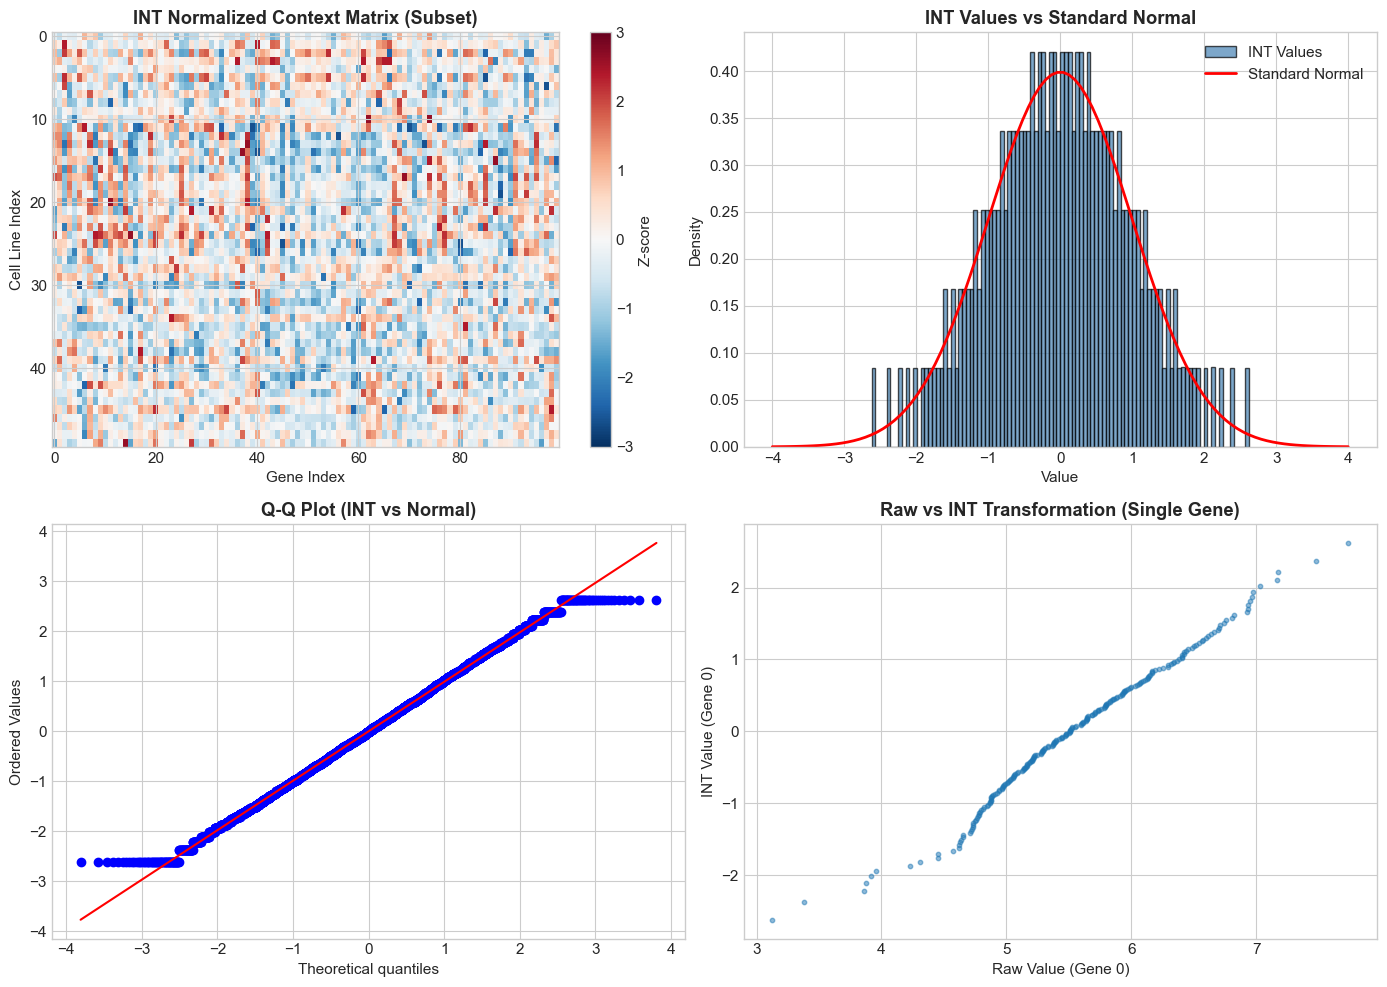


   ✓ INT normalization successful!


In [12]:
# 可视化INT归一化效果
print("\n📊 Visualizing INT Normalized Contexts...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 热图
ax1 = axes[0, 0]
n_cells_show = min(50, int_matrix.shape[0])
n_genes_show = 100
im = ax1.imshow(int_matrix[:n_cells_show, :n_genes_show], aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
ax1.set_xlabel('Gene Index')
ax1.set_ylabel('Cell Line Index')
ax1.set_title('INT Normalized Context Matrix (Subset)', fontweight='bold')
plt.colorbar(im, ax=ax1, label='Z-score')

# 整体分布（与标准正态对比）
ax2 = axes[0, 1]
ax2.hist(int_matrix.flatten(), bins=100, density=True, color='steelblue', 
         edgecolor='black', alpha=0.7, label='INT Values')
x = np.linspace(-4, 4, 100)
ax2.plot(x, stats.norm.pdf(x), 'r-', linewidth=2, label='Standard Normal')
ax2.set_xlabel('Value')
ax2.set_ylabel('Density')
ax2.set_title('INT Values vs Standard Normal', fontweight='bold')
ax2.legend()

# Q-Q Plot
ax3 = axes[1, 0]
sample_values = np.random.choice(int_matrix.flatten(), size=10000, replace=False)
stats.probplot(sample_values, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot (INT vs Normal)', fontweight='bold')

# 前后对比（选择一个基因）
ax4 = axes[1, 1]
gene_idx = 0
ax4.scatter(context_matrix_raw[:, gene_idx], int_matrix[:, gene_idx], alpha=0.5, s=10)
ax4.set_xlabel(f'Raw Value (Gene {gene_idx})')
ax4.set_ylabel(f'INT Value (Gene {gene_idx})')
ax4.set_title('Raw vs INT Transformation (Single Gene)', fontweight='bold')

plt.tight_layout()
plt.savefig(VIZ_DIR / 'int_normalization_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n   ✓ INT normalization successful!")

## 8. 构建最终数据集

In [13]:
def build_cell_id_mapping(cell_contexts: Dict[str, np.ndarray],
                          training_meta: pd.DataFrame) -> Dict[str, int]:
    """构建细胞系ID到索引的映射"""
    print("\n" + "=" * 80)
    print("🏷️  Building Cell Line ID Mapping")
    print("=" * 80)
    
    training_cells = set(training_meta['cell_iname'].unique())
    context_cells = set(cell_contexts.keys())
    
    common_cells = training_cells & context_cells
    missing_cells = training_cells - context_cells
    
    print(f"   Training data cell lines: {len(training_cells)}")
    print(f"   Cell lines with context: {len(context_cells)}")
    print(f"   Common cell lines: {len(common_cells)}")
    print(f"   Missing cell lines: {len(missing_cells)}")
    
    if missing_cells:
        print(f"\n   ⚠️  Missing cell lines: {list(missing_cells)[:10]}...")
    
    # 构建映射
    sorted_cells = sorted(list(common_cells))
    cell_id_to_idx = {cell: idx for idx, cell in enumerate(sorted_cells)}
    
    print(f"\n   ✓ Built mapping for {len(cell_id_to_idx)} cell lines")
    
    return cell_id_to_idx, missing_cells

# 构建映射
cell_id_to_idx, missing_cells = build_cell_id_mapping(
    cell_contexts_int, 
    training_data['sample_meta']
)


🏷️  Building Cell Line ID Mapping
   Training data cell lines: 57
   Cell lines with context: 227
   Common cell lines: 57
   Missing cell lines: 0

   ✓ Built mapping for 57 cell lines


In [14]:
def match_contexts_to_samples(training_data: Dict,
                               cell_contexts: Dict[str, np.ndarray],
                               cell_id_to_idx: Dict[str, int]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """将细胞系上下文匹配到训练样本"""
    print("\n" + "=" * 80)
    print("🔗 Matching Contexts to Training Samples")
    print("=" * 80)
    
    meta = training_data['sample_meta']
    n_samples = len(meta)
    n_genes = 978
    
    context_matrix = np.zeros((n_samples, n_genes), dtype=np.float32)
    cell_ids = np.zeros(n_samples, dtype=np.int32)
    has_context_mask = np.zeros(n_samples, dtype=bool)
    
    print(f"   Processing {n_samples:,} samples...")
    
    n_matched = 0
    n_missing = 0
    
    for idx in tqdm(range(len(meta)), desc="   Matching"):
        cell_iname = meta.iloc[idx]['cell_iname']
        
        if cell_iname in cell_contexts and cell_iname in cell_id_to_idx:
            context_matrix[idx] = cell_contexts[cell_iname]
            cell_ids[idx] = cell_id_to_idx[cell_iname]
            has_context_mask[idx] = True
            n_matched += 1
        else:
            context_matrix[idx] = np.zeros(n_genes, dtype=np.float32)
            cell_ids[idx] = -1
            has_context_mask[idx] = False
            n_missing += 1
    
    print(f"\n   ✓ Matched: {n_matched:,} ({n_matched/n_samples*100:.1f}%)")
    print(f"   ⚠️  Missing: {n_missing:,} ({n_missing/n_samples*100:.1f}%)")
    
    return context_matrix, cell_ids, has_context_mask

# 匹配上下文
X_ctx, cell_ids_array, has_context_mask = match_contexts_to_samples(
    training_data, cell_contexts_int, cell_id_to_idx
)


🔗 Matching Contexts to Training Samples
   Processing 509,006 samples...


   Matching:   0%|          | 0/509006 [00:00<?, ?it/s]


   ✓ Matched: 509,006 (100.0%)
   ⚠️  Missing: 0 (0.0%)


In [15]:
# 构建最终数据集
print("\n" + "=" * 80)
print("🚀 Building Final HCA-DR Dataset")
print("=" * 80)

# 过滤没有上下文的样本
FILTER_NO_CONTEXT = True

if FILTER_NO_CONTEXT:
    valid_mask = has_context_mask
    n_before = len(has_context_mask)
    n_after = valid_mask.sum()
    
    print(f"   Filtering samples without context...")
    print(f"   Before: {n_before:,}")
    print(f"   After: {n_after:,}")
    print(f"   Removed: {n_before - n_after:,}")
    
    # 过滤数据
    X_pert = training_data['X'][valid_mask]
    X_ctx_filtered = X_ctx[valid_mask]
    cell_ids_filtered = cell_ids_array[valid_mask]
    folds = training_data['folds'][valid_mask]
    sample_meta = training_data['sample_meta'][valid_mask].reset_index(drop=True)
    
    # 重新构建化合物标签
    unique_perts = sorted(sample_meta['pert_id'].unique())
    new_pert_to_idx = {pert: idx for idx, pert in enumerate(unique_perts)}
    y = np.array([new_pert_to_idx[p] for p in sample_meta['pert_id']], dtype=np.int32)
    
    compound_names = unique_perts
    pert_to_idx = new_pert_to_idx
else:
    X_pert = training_data['X']
    X_ctx_filtered = X_ctx
    cell_ids_filtered = cell_ids_array
    folds = training_data['folds']
    sample_meta = training_data['sample_meta']
    y = training_data['y']
    compound_names = training_data['compound_names']
    pert_to_idx = training_data['pert_to_idx']

print(f"\n   ✓ X_pert shape: {X_pert.shape}")
print(f"   ✓ X_ctx shape: {X_ctx_filtered.shape}")
print(f"   ✓ y shape: {y.shape}")
print(f"   ✓ cell_ids shape: {cell_ids_filtered.shape}")


🚀 Building Final HCA-DR Dataset
   Filtering samples without context...
   Before: 509,006
   After: 509,006
   Removed: 0

   ✓ X_pert shape: (509006, 978)
   ✓ X_ctx shape: (509006, 978)
   ✓ y shape: (509006,)
   ✓ cell_ids shape: (509006,)


In [16]:
# 构建最终数据字典
hca_dr_data = {
    # 核心数据
    'X_pert': X_pert,                    # 扰动签名 (n_samples, 978)
    'X_ctx': X_ctx_filtered,             # 细胞系上下文 (n_samples, 978)
    'y': y,                              # 药物标签 (n_samples,)
    'cell_ids': cell_ids_filtered,       # 细胞系ID (n_samples,)
    'folds': folds,                      # 交叉验证折 (n_samples,)
    
    # 元数据
    'sample_meta': sample_meta,
    'gene_names': training_data['gene_names'],
    'compound_names': compound_names,
    'pert_to_idx': pert_to_idx,
    'cell_id_to_idx': cell_id_to_idx,
    'idx_to_cell_id': {v: k for k, v in cell_id_to_idx.items()},
    
    # 原始上下文（用于分析）
    'cell_contexts_raw': cell_contexts_raw,
    'cell_contexts_int': cell_contexts_int,
    
    # 统计信息
    'n_samples': len(X_pert),
    'n_compounds': len(compound_names),
    'n_genes': X_pert.shape[1],
    'n_cell_lines': len(cell_id_to_idx),
}

print("\n" + "=" * 80)
print("✅ HCA-DR Dataset Summary")
print("=" * 80)
print(f"   • Samples: {hca_dr_data['n_samples']:,}")
print(f"   • Compounds: {hca_dr_data['n_compounds']:,}")
print(f"   • Genes: {hca_dr_data['n_genes']}")
print(f"   • Cell lines: {hca_dr_data['n_cell_lines']}")


✅ HCA-DR Dataset Summary
   • Samples: 509,006
   • Compounds: 10,107
   • Genes: 978
   • Cell lines: 57


## 9. 保存数据

In [17]:
# 保存
output_path = OUTPUT_DIR / OUTPUT_FILE
print(f"\n💾 Saving HCA-DR data to: {output_path}")

with open(output_path, 'wb') as f:
    pickle.dump(hca_dr_data, f, protocol=4)

file_size_mb = output_path.stat().st_size / (1024**2)
print(f"   ✓ Saved successfully! ({file_size_mb:.1f} MB)")


💾 Saving HCA-DR data to: D:\科研\Models\drugreflector\processed_data\hca_dr_training_data_l.pkl
   ✓ Saved successfully! (3944.3 MB)


## 10. 数据验证

In [18]:
# 验证加载
print("\n📖 Verifying saved data...")

with open(output_path, 'rb') as f:
    loaded_data = pickle.load(f)

print(f"\n   ✓ Data keys: {list(loaded_data.keys())}")
print(f"   ✓ X_pert shape: {loaded_data['X_pert'].shape}")
print(f"   ✓ X_ctx shape: {loaded_data['X_ctx'].shape}")
print(f"   ✓ y shape: {loaded_data['y'].shape}")
print(f"   ✓ cell_ids shape: {loaded_data['cell_ids'].shape}")

# 验证数据一致性
assert np.array_equal(loaded_data['X_pert'], hca_dr_data['X_pert']), "X_pert mismatch!"
assert np.array_equal(loaded_data['X_ctx'], hca_dr_data['X_ctx']), "X_ctx mismatch!"
assert np.array_equal(loaded_data['y'], hca_dr_data['y']), "y mismatch!"
print(f"\n   ✓ Data integrity verified!")


📖 Verifying saved data...

   ✓ Data keys: ['X_pert', 'X_ctx', 'y', 'cell_ids', 'folds', 'sample_meta', 'gene_names', 'compound_names', 'pert_to_idx', 'cell_id_to_idx', 'idx_to_cell_id', 'cell_contexts_raw', 'cell_contexts_int', 'n_samples', 'n_compounds', 'n_genes', 'n_cell_lines']
   ✓ X_pert shape: (509006, 978)
   ✓ X_ctx shape: (509006, 978)
   ✓ y shape: (509006,)
   ✓ cell_ids shape: (509006,)

   ✓ Data integrity verified!



📊 Final Data Visualization...


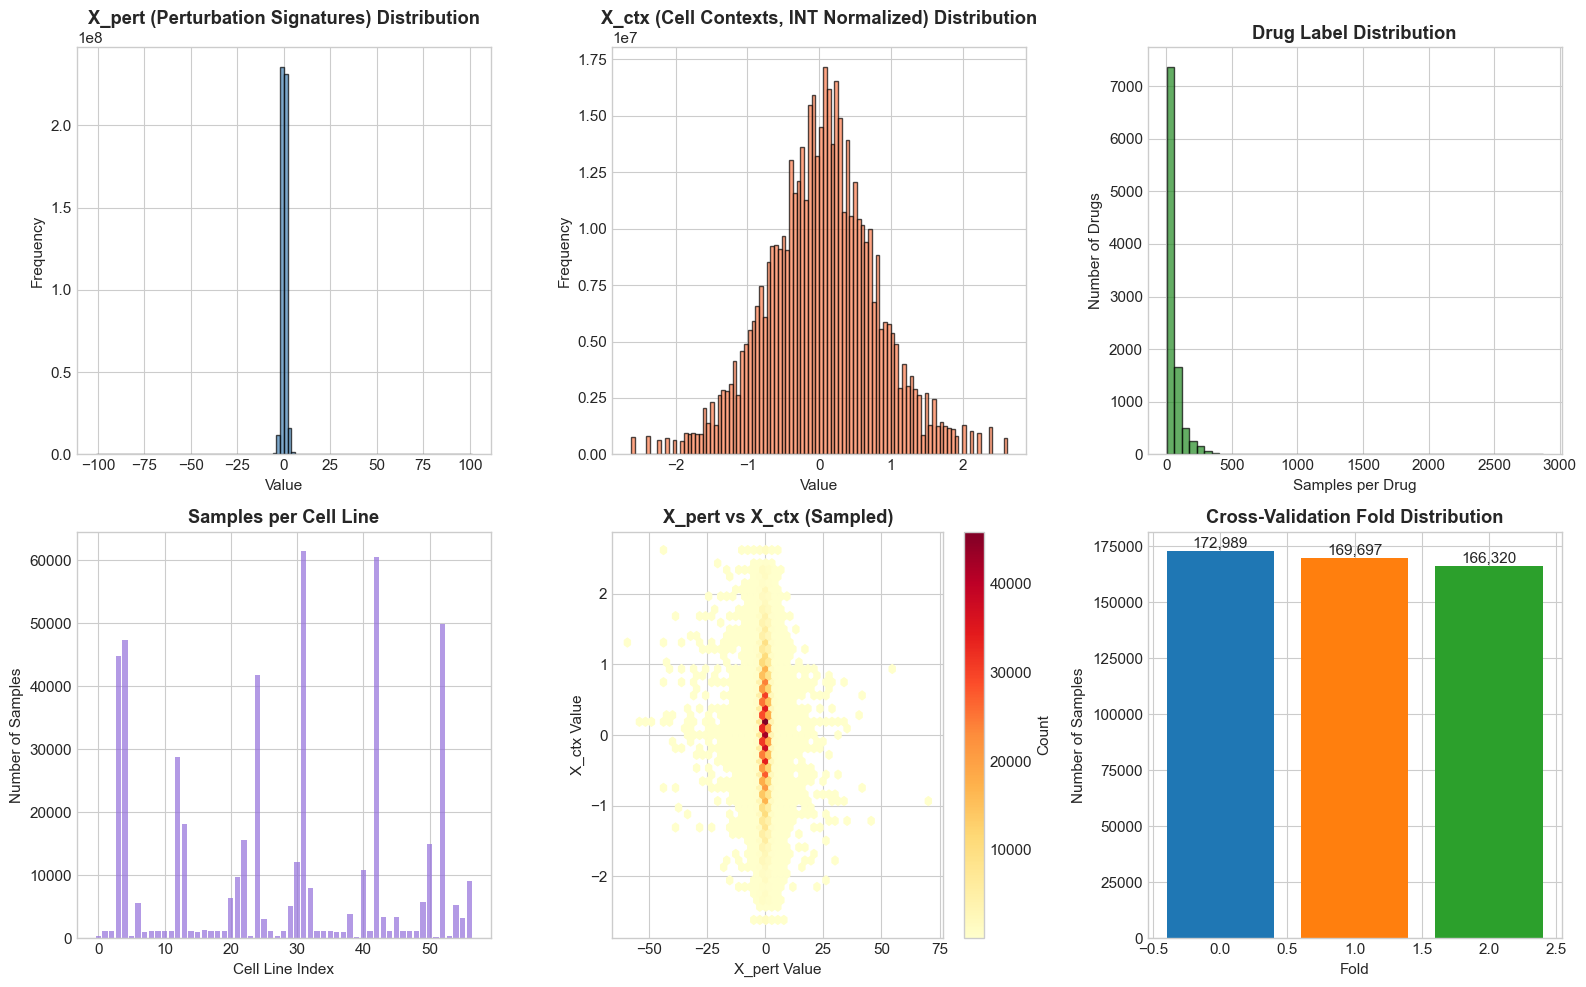


🎯 HCA-DR Data Preprocessing Complete!
   Output: D:\科研\Models\drugreflector\processed_data\hca_dr_training_data_l.pkl


In [19]:
# 最终可视化
print("\n📊 Final Data Visualization...")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. X_pert分布
ax1 = axes[0, 0]
ax1.hist(loaded_data['X_pert'].flatten(), bins=100, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.set_title('X_pert (Perturbation Signatures) Distribution', fontweight='bold')

# 2. X_ctx分布
ax2 = axes[0, 1]
ax2.hist(loaded_data['X_ctx'].flatten(), bins=100, color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')
ax2.set_title('X_ctx (Cell Contexts, INT Normalized) Distribution', fontweight='bold')

# 3. 药物标签分布
ax3 = axes[0, 2]
drug_counts = pd.Series(loaded_data['y']).value_counts().sort_index()
ax3.hist(drug_counts.values, bins=50, color='forestgreen', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Samples per Drug')
ax3.set_ylabel('Number of Drugs')
ax3.set_title('Drug Label Distribution', fontweight='bold')

# 4. 细胞系ID分布
ax4 = axes[1, 0]
cell_counts = pd.Series(loaded_data['cell_ids']).value_counts().sort_index()
ax4.bar(range(len(cell_counts)), cell_counts.values, color='mediumpurple', alpha=0.7)
ax4.set_xlabel('Cell Line Index')
ax4.set_ylabel('Number of Samples')
ax4.set_title('Samples per Cell Line', fontweight='bold')

# 5. X_pert vs X_ctx相关性（随机采样）
ax5 = axes[1, 1]
sample_idx = np.random.choice(len(loaded_data['X_pert']), size=1000, replace=False)
pert_sample = loaded_data['X_pert'][sample_idx].flatten()
ctx_sample = loaded_data['X_ctx'][sample_idx].flatten()
ax5.hexbin(pert_sample, ctx_sample, gridsize=50, cmap='YlOrRd', mincnt=1)
ax5.set_xlabel('X_pert Value')
ax5.set_ylabel('X_ctx Value')
ax5.set_title('X_pert vs X_ctx (Sampled)', fontweight='bold')
plt.colorbar(ax5.collections[0], ax=ax5, label='Count')

# 6. 交叉验证折分布
ax6 = axes[1, 2]
fold_counts = pd.Series(loaded_data['folds']).value_counts().sort_index()
bars = ax6.bar(fold_counts.index, fold_counts.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax6.set_xlabel('Fold')
ax6.set_ylabel('Number of Samples')
ax6.set_title('Cross-Validation Fold Distribution', fontweight='bold')
for bar, val in zip(bars, fold_counts.values):
    ax6.text(bar.get_x() + bar.get_width()/2, val, f'{val:,}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(VIZ_DIR / 'hca_dr_final_data_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🎯 HCA-DR Data Preprocessing Complete!")
print(f"   Output: {output_path}")

## 11. 使用示例

In [20]:
# 展示如何使用数据进行训练
print("\n" + "=" * 80)
print("📝 Usage Example for HCA-DR Training")
print("=" * 80)

example_code = '''
# 加载HCA-DR数据
import pickle
import torch
from torch.utils.data import Dataset, DataLoader

with open("hca_dr_training_data.pkl", "rb") as f:
    data = pickle.load(f)

# 创建PyTorch Dataset
class HCADRDataset(Dataset):
    def __init__(self, data, fold_ids, mode="train"):
        """
        HCA-DR数据集
        
        参数：
            data: HCA-DR数据字典
            fold_ids: 用于训练/验证的fold列表
            mode: "train" 或 "val"
        """
        mask = np.isin(data["folds"], fold_ids)
        
        self.X_pert = torch.FloatTensor(data["X_pert"][mask])
        self.X_ctx = torch.FloatTensor(data["X_ctx"][mask])
        self.y = torch.LongTensor(data["y"][mask])
        self.cell_ids = torch.LongTensor(data["cell_ids"][mask])
        
        self.context_dropout = 0.15 if mode == "train" else 0.0
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x_pert = self.X_pert[idx]
        x_ctx = self.X_ctx[idx]
        
        # Context Dropout（训练时）
        if np.random.random() < self.context_dropout:
            x_ctx = torch.zeros_like(x_ctx)
            is_dropout = 1
        else:
            is_dropout = 0
        
        return {
            "x_pert": x_pert,
            "x_ctx": x_ctx,
            "y": self.y[idx],
            "cell_id": self.cell_ids[idx],
            "is_dropout": is_dropout
        }

# 创建DataLoader
train_dataset = HCADRDataset(data, fold_ids=[0, 1], mode="train")
val_dataset = HCADRDataset(data, fold_ids=[2], mode="val")

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
'''

print(example_code)


📝 Usage Example for HCA-DR Training

# 加载HCA-DR数据
import pickle
import torch
from torch.utils.data import Dataset, DataLoader

with open("hca_dr_training_data.pkl", "rb") as f:
    data = pickle.load(f)

# 创建PyTorch Dataset
class HCADRDataset(Dataset):
    def __init__(self, data, fold_ids, mode="train"):
        """
        HCA-DR数据集
        
        参数：
            data: HCA-DR数据字典
            fold_ids: 用于训练/验证的fold列表
            mode: "train" 或 "val"
        """
        mask = np.isin(data["folds"], fold_ids)
        
        self.X_pert = torch.FloatTensor(data["X_pert"][mask])
        self.X_ctx = torch.FloatTensor(data["X_ctx"][mask])
        self.y = torch.LongTensor(data["y"][mask])
        self.cell_ids = torch.LongTensor(data["cell_ids"][mask])
        
        self.context_dropout = 0.15 if mode == "train" else 0.0
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x_pert = self.X_pert[idx]
        x_ctx = self.X_ctx[idx]
   

In [21]:
print("\n" + "=" * 80)
print("✅ ALL PREPROCESSING COMPLETE!")
print("=" * 80)
print(f"\n📁 Output files:")
print(f"   • Data: {OUTPUT_DIR / OUTPUT_FILE}")
print(f"   • Visualizations: {VIZ_DIR}")
print(f"\n🎯 Ready for HCA-DR model training!")


✅ ALL PREPROCESSING COMPLETE!

📁 Output files:
   • Data: D:\科研\Models\drugreflector\processed_data\hca_dr_training_data_l.pkl
   • Visualizations: D:\科研\Models\drugreflector\visualizations\hca_dr

🎯 Ready for HCA-DR model training!
